In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import sys
import datetime
import plotly.express as px
from scipy import stats

In [2]:
#imports for deceision tree:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_boston
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# Parameters:

In [3]:
# analysis parameters:
#######################
#1. rolling
summing_over_n_days=10
#2. relevant symptoms
#all_sympt=('symptom_smell_or_taste_loss','symptom_diarrhea','symptom_fatigue','symptom_cough_dry','symptom_cough_moist','symptom_fever','symptom_runny_nose','condition_diabetes')
#relevant_sympt=['symptom_smell_or_taste_loss','symptom_diarrhea','symptom_fatigue','symptom_cough_moist','symptom_fever']
relevant_sympt=['symptom_smell_or_taste_loss','symptom_diarrhea','symptom_fatigue']

# Load data:

In [4]:
#loda the proc data:
path2data = '/Users/tamarstolero/Dropbox (Weizmann Institute)/courses/Project in data science/Data/'#
#path2data =''

df_sympt_for_analysis_bot=pd.read_pickle(path2data+'df_sympt_for_analysis_bot.pkl')
few_many_df=pd.read_pickle(path2data+'few_many_df.pkl')
new_df_lab2=pd.read_pickle(path2data+'new_df_lab2')
df_label_new=pd.read_pickle(path2data+'df_label.pkl')


# Prepare data for analysis:

In [5]:
# proc data:
######################
# 1. do a rolling sum on the symptoms data 
#-----------------------------------------
df_sympt_for_analysis_bot_running_sum = df_sympt_for_analysis_bot.groupby(level=[0]).rolling(summing_over_n_days).sum()
#drop the double city id column
df_sympt_for_analysis_bot_running_sum=df_sympt_for_analysis_bot_running_sum.droplevel(0)
#drop nan lines:
df_sympt_for_analysis_bot_running_sum=df_sympt_for_analysis_bot_running_sum.dropna()

# 2. choose sympt and divide by N daily
#----------------------------------------
columns_to_keep = relevant_sympt+['N_daily']
df_sympt_classification_all_cities=df_sympt_for_analysis_bot_running_sum[columns_to_keep]
for sympt_str in relevant_sympt:
    df_sympt_classification_all_cities[sympt_str]=df_sympt_for_analysis_bot_running_sum[sympt_str]/df_sympt_for_analysis_bot_running_sum['N_daily']

# 3. choose relevant cities
#-----------------------------------------
#cities_for_analysis=list(few_many_df.index)
#df_sympt_classification=df_sympt_classification_all_cities.loc[cities_for_analysis]

# 4. add labels to data:
#-----------------------------------------
df_sympt_and_labels_classification=df_label_new.join(df_sympt_classification_all_cities,how='inner')



/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [7]:
df_sympt_and_labels_classification.shape[0]

497

# Classification:

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.901


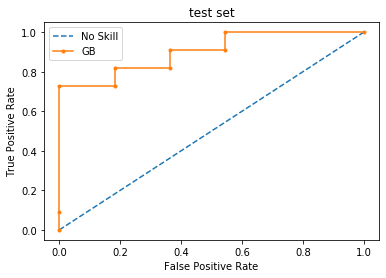

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.811


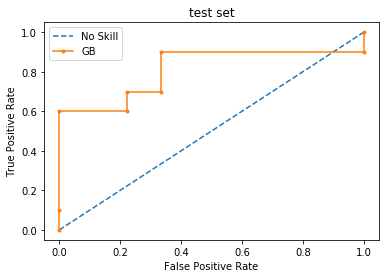

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.710


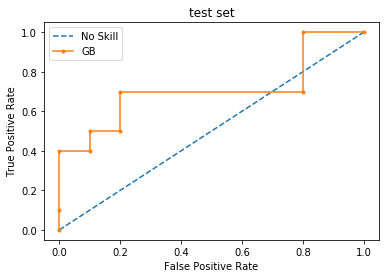

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.744


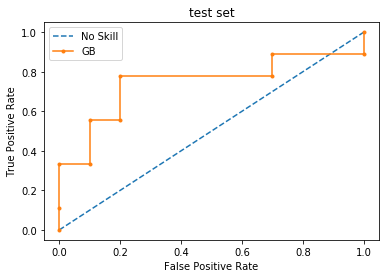

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.800


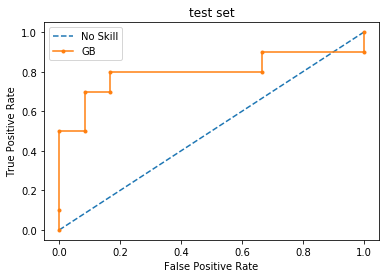

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.694


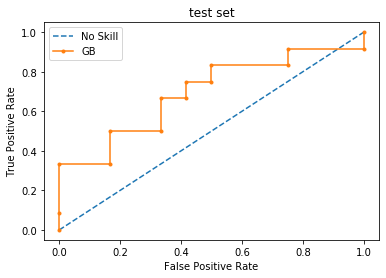

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.769


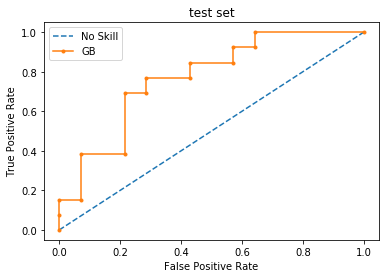

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.632


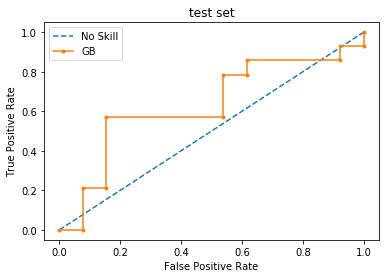

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.676


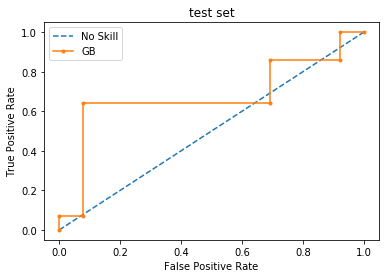

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.606


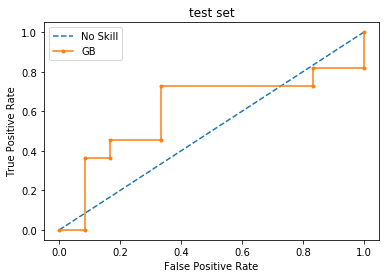

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.515


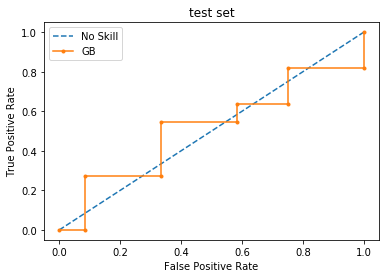

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.670


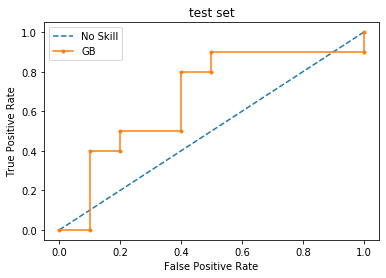

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.742


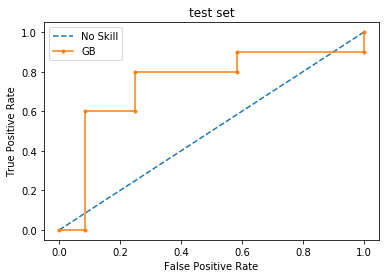

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.630


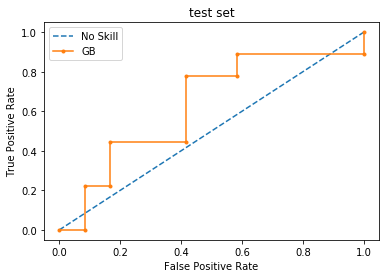

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.667


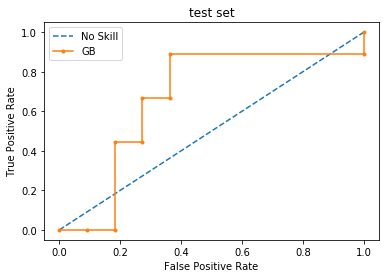

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.479


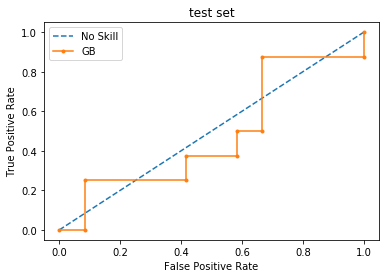

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.468


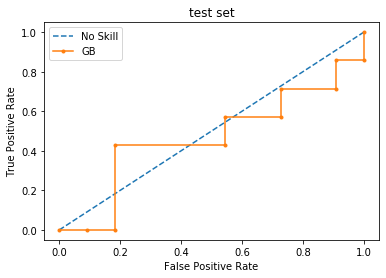

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.756


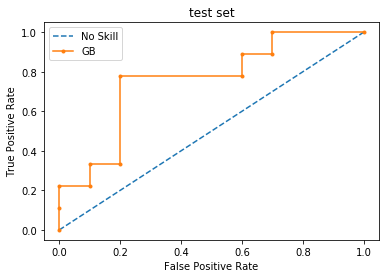

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.542


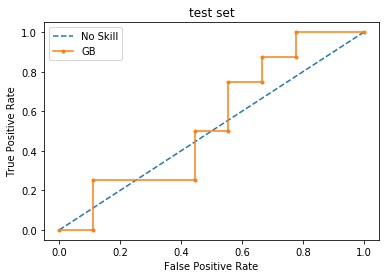

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.492


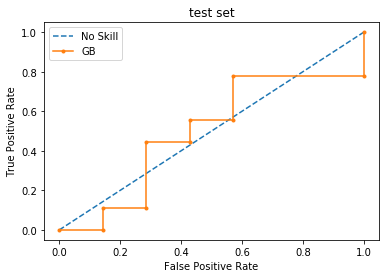

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.250


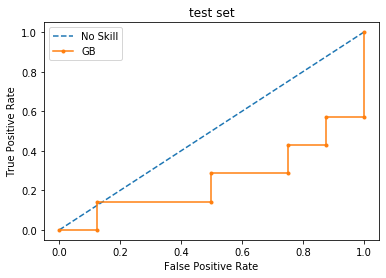

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.554


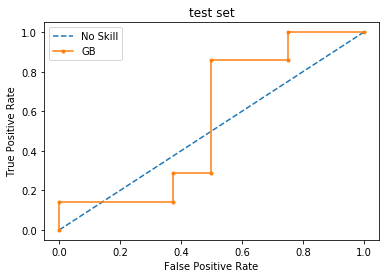

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.714


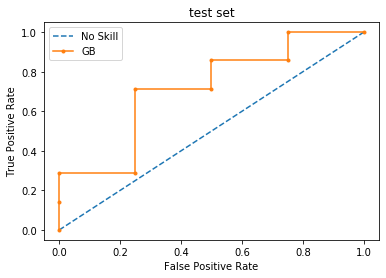

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.571


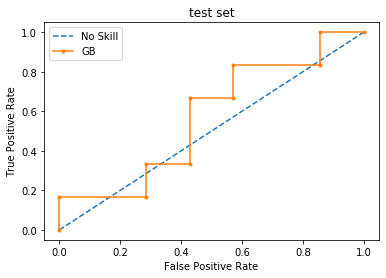

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.738


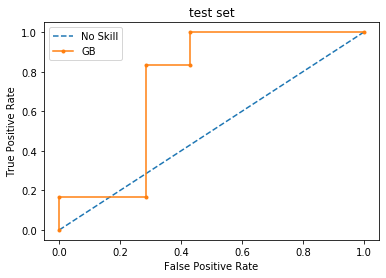

In [109]:
# run clasification algoritm on the "rolled" symptoms and check the error (leave one out) over different dates

x=df_sympt_and_labels_classification.reset_index()
dates=np.unique(x['date'].values)
date_i=0
learning_rates = [0.001, 0.0005, 0.001, 0.005, 0.01, 0.05]
mean_AUC_test_all_dates=np.empty(shape=[len(dates)])
mean_AUC_train_all_dates=np.empty(shape=[len(dates)])
error_AUC_train_all_dates=np.empty(shape=[len(dates)])
error_AUC_test_all_dates=np.empty(shape=[len(dates)])
n_cities=np.empty(shape=[len(dates)])
mean_n_daily=np.empty(shape=[len(dates)])
error_n_daily=np.empty(shape=[len(dates)])

y_test_predict_all_cities=np.empty(shape=[df_sympt_and_labels_classification.shape[0]])
y_test_all_cities=np.empty(shape=[df_sympt_and_labels_classification.shape[0]])
cities_all = np.empty(shape=[df_sympt_and_labels_classification.shape[0]])
N_daily_all = np.empty(shape=[df_sympt_and_labels_classification.shape[0]])

city_j = 0
# for loop running over days
for i in dates:
    # arange data for classifiction per date
    #----------------------------------------
    x=df_sympt_and_labels_classification.iloc[df_sympt_and_labels_classification.index.get_level_values('date')==i]
    y=x.labels
    x=x.droplevel([1])
    y=y.droplevel([1])

    X=x[relevant_sympt]
    y=pd.DataFrame(y)


    #scale data:
    #----------------------------------------
    # I saw they did it in on link : https://blog.paperspace.com/gradient-boosting-for-classification/ 
    # need to check if we need it!
    #I didn't see a difference and I think we don't need to scale because all of our data in the same scale

    #scaler = MinMaxScaler()
    #X_train_scale = scaler.fit_transform(X)
    
    #no scaling:
    X_train_scale=X.values

    
    # Run over different cities as train and test (manually leave on out)
    #---------------------------------------------------------------------
    #NEED to find if there is a different way to do it
    
    #initialize:
    #accuracy_score_test=np.empty(shape=[len(X_train_scale),len(learning_rates)])
    #accuracy_score_train=np.empty(shape=[len(X_train_scale),len(learning_rates)])
    #AUC_test=np.empty(shape=[len(X_train_scale),len(learning_rates)])
    #AUC_train=np.empty(shape=[len(X_train_scale),len(learning_rates)])
    accuracy_score_test=np.empty(shape=[len(X_train_scale)])
    accuracy_score_train=np.empty(shape=[len(X_train_scale)])
    AUC_test=np.empty(shape=[len(X_train_scale)])
    AUC_train=np.empty(shape=[len(X_train_scale)])
    y_test_predict=np.empty(shape=[len(X_train_scale)])
    y_test_all=np.empty(shape=[len(X_train_scale)])

    #loo = LeaveOneOut()
    #loo.get_n_splits(X)
    #print(loo)
    #for train_index, test_index in loo.split(X):
        
    for train_i in list(range(len(X_train_scale))):
        # split to train and test:
        #-------------------------
        X_train=np.append(X_train_scale[:train_i,:], X_train_scale[train_i+1:,:],axis=0)
        X_test=X_train_scale[train_i,:].reshape(1,3)
        y_train=np.append(y.iloc[:train_i].values, y.iloc[train_i+1:].values)
        y_test=y.iloc[train_i].values
        #lr_i=0
        
        # run over different learning rates:
        #-----------------------------------
        #for learning_rate in learning_rates:       
        gb = GradientBoostingClassifier(n_estimators=1000,max_leaf_nodes=8, learning_rate = 0.001, max_depth = 1000, random_state = 0,subsample=0.5)
        gb.fit(X_train, y_train)
            
        accuracy_score_train[train_i]=gb.score(X_train, y_train)
        accuracy_score_test[train_i]=gb.score(X_test, y_test)
        AUC_train[train_i]=roc_auc_score(y_train, gb.predict_proba(X_train)[:,1])
        y_test_predict[train_i]=gb.predict_proba(X_test)[:,1]
        y_test_all[train_i]=y_test
        
        y_test_predict_all_cities[city_j]=gb.predict_proba(X_test)[:,1]
        y_test_all_cities[city_j]=y_test 
        cities_all[city_j]=x.index[train_i]
        N_daily_all[city_j] = x['N_daily'].iloc[0]
        
        city_j = city_j+1
            #lr_i=lr_i+1
    # plot test
    ns_probs = [0 for _ in range(len(y_test_all))]
    lr_probs = y_test_predict
    #lr_probs = lr_probs[:, 1]
    ns_auc = roc_auc_score(y_test_all, ns_probs)
    lr_auc = roc_auc_score(y_test_all, lr_probs)
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Logistic: ROC AUC=%.3f' % (lr_auc))
    ns_fpr, ns_tpr, _ = roc_curve(y_test_all, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test_all, lr_probs)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='GB')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    plt.title('test set')
    # show the plot
    plt.show()
    
    # average accuracy over all different tets/train sets:
    #----------------------------------------------------- 
    #AUC_test[date_i]=roc_auc_score(y_test_all, y_test_predict)
    mean_AUC_test_all_dates[date_i]=roc_auc_score(y_test_all, y_test_predict)
    mean_AUC_train_all_dates[date_i]=np.nanmean(AUC_train,axis=0)
    #error_AUC_train_all_dates[date_i]=np.nanstd(AUC_train,axis=0)/len(AUC_train)
    #error_AUC_test_all_dates[date_i]=np.nanstd(AUC_test,axis=0)/len(AUC_test)
    n_cities[date_i]=len(AUC_test)
    mean_n_daily[date_i]=np.nanmean(x.N_daily)
    error_n_daily[date_i]=np.nanmean(x.N_daily)/len(AUC_test)
    date_i=date_i+1
    

In [112]:
tmp = pd.DataFrame([cities_all, y_test_all_cities,y_test_predict_all_cities,N_daily_all])
pd_classification_by_city = tmp.T

#pd_classification_by_city['correct_classification'] =  pd_classification_by_city[1]>0.5 *  pd_classification_by_city[2]>0.5
pd_classification_by_city['correct_classification'] = ((pd_classification_by_city[1]>0.5).values&(pd_classification_by_city[2]>0.5).values) |((pd_classification_by_city[1]<0.5).values&(pd_classification_by_city[2]<0.5).values) 
pd_classification_by_city['n'] = np.ones(shape=[len(cities_all)])

pd_classification_prop_by_city = pd_classification_by_city.groupby(0).mean()
pd_classification_prop_by_city['n'] = pd_classification_by_city.groupby(0).sum()['n']
pd_classification_prop_by_city = pd_classification_prop_by_city[pd_classification_prop_by_city['n']>10]
pd_classification_prop_by_city

,1,2,3,correct_classification,n
0,,,,,
44.0,1.000000,0.491397,1271.555556,0.500000,18.0
93.0,0.000000,0.438848,1522.272727,0.636364,11.0
148.0,1.000000,0.682669,1258.526316,1.000000,19.0
489.0,1.000000,0.609806,1468.571429,0.642857,14.0
695.0,0.000000,0.241729,1125.454545,1.000000,11.0
764.0,1.000000,0.500013,1510.727273,0.454545,11.0
902.0,0.846154,0.328102,1272.230769,0.153846,13.0
1014.0,0.000000,0.480210,1184.476190,0.619048,21.0
1015.0,0.000000,0.422259,1264.076923,0.692308,13.0


,1,2,3,correct_classification,n
1,1.000000,0.401021,0.182656,-0.127255,0.295602
2,0.401021,1.000000,-0.147947,-0.207632,0.052266
3,0.182656,-0.147947,1.000000,0.064516,-0.215856
correct_classification,-0.127255,-0.207632,0.064516,1.000000,-0.010734
n,0.295602,0.052266,-0.215856,-0.010734,1.000000


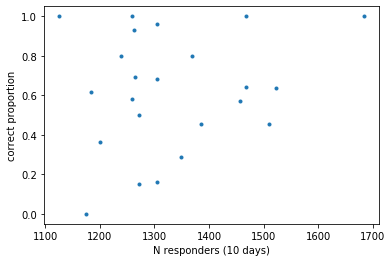

In [118]:
plt.plot(pd_classification_prop_by_city[3], pd_classification_prop_by_city['correct_classification'],'.')
plt.xlabel('N responders (10 days)')
plt.ylabel('correct proportion')
pd_classification_prop_by_city.corr(method ='spearman') 

In [ ]:
p=plt.plot(dates,mean_AUC_test_all_dates)
p=plt.xlabel('date')
p=plt.ylabel('AUC')
p=plt.xticks(rotation=70)
p=plt.title('Gradient boosting AUC per date')

In [ ]:
#plot with errorbar
p=plt.plot(dates,mean_AUC_test_all_dates)
p=plt.xlabel('date')
p=plt.ylabel('AUC')
p=plt.xticks(rotation=70)
p=plt.title('Gradient boosting AUC per date')


In [ ]:
#plot n cities per day
p=plt.plot(dates,n_cities)
p=plt.xlabel('date')
p=plt.ylabel('# cities')
p=plt.xticks(rotation=70)


In [ ]:
#plot n cities per day
p=plt.errorbar(dates,mean_n_daily, error_n_daily)

p=plt.plot(dates,mean_n_daily)
p=plt.xlabel('date')
p=plt.ylabel('mean N daily')
p=plt.xticks(rotation=70)


In [ ]:
# plot the error vs. the date of symptoms 
# we should get reduction of error over days
# we hope to find that a week before we have resonable error

p=plt.plot(dates,mean_accuracy_test_all_dates)
p=plt.xlabel('date')
p=plt.ylabel('test accuracy')
#plt.legend[learning_rates]


In [ ]:
p=plt.plot(dates,mean_accuracy_train_all_dates)
p=plt.xlabel('date')
p=plt.ylabel('accuracy')
#plt.legend[learning_rates]

In [ ]:
def classification_GradientBoosting(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=1/len(y))
    
    regressor = GradientBoostingRegressor(
    max_depth=2,
    n_estimators=3,
    learning_rate=1.0
    )
    regressor.fit(X_train, y_train)
    errors = [mean_squared_error(y_test, y_pred) for y_pred in regressor.staged_predict(X_test)]
    best_n_estimators = np.argmin(errors)
    min_error=np.min(errors)
    #########################################
    # NEED to add here runing over differnt test sets!!
    ########################################
    return min_error, best_n_estimators